## Finding Your Way In The City

In this notebook we combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

We reuse and modify our algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from grid import create_grid
from planning import a_star

%matplotlib inline

#from bresenham import bresenham

plt.rcParams['figure.figsize'] = 13, 13

Notice that we import `create_grid`, and `a_star`. These are functions implemented in previous exercises, and here we use them to create a map and find a path from a starting position to a goal position.

They are stored in [grid.py](grid.py) and [planning.py](planning.py) files, placed in the current directory.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [8]:
?create_grid

### Read the obstacle map

In [10]:
# Read the obstacle data contained in the file: colliders.csv
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


### Create a grid configuration space fo the obstacle data

In [11]:
# Static drone altitude (meters)
drone_altitude = 7

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

# Create a grid configuration space of the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

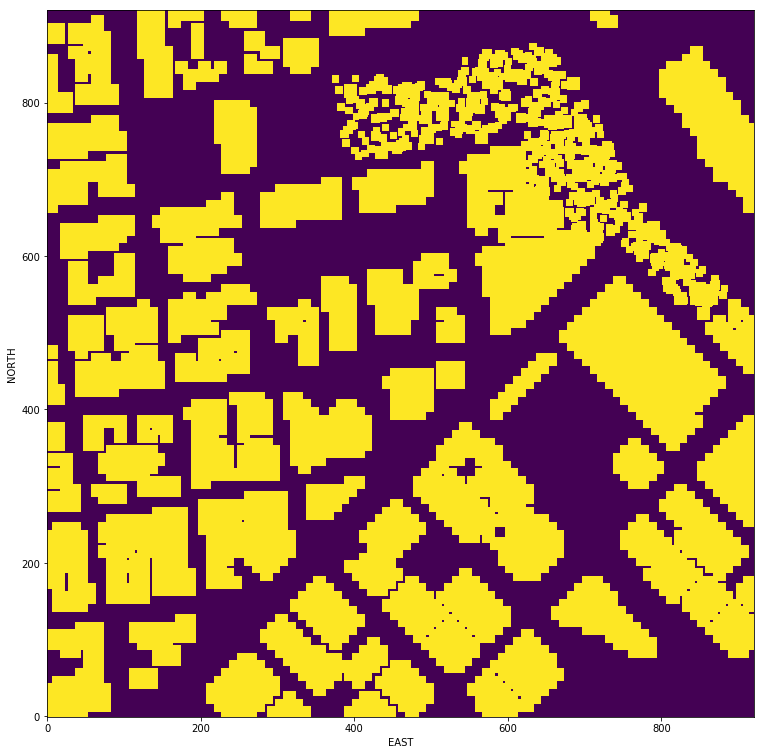

In [12]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

### Write a heuristic function.

The [heuristic function](https://en.wikipedia.org/wiki/Heuristic_(computer_science)) determines the $h()$ value for each cell based on the goal cell and the method chosen to determine it. The heuristic value can be the Euclidean distance between these cells $h= \left((x_i-x_{goal})^2+(y_i-y_{goal})^2\right)^{1/2}$ or the "Manhattan distance", which is the minimum number of moves required to reach the goal from the assigned cell $h = ||x_i-x_{goal}|| + ||y_i-y_{goal}||$. For this exercise you could use either, or something else which is *admissible* and *consistent*.

The input variables include
* **```position```** the coordinates of the cell for which you would like to determine the heuristic value.
* **```goal_position```** the coordinates of the goal cell

In [13]:
def Euclidean_d(position, goal_position):
    dx = goal_position[0] - position[0]
    dy = goal_position[1] - position[1] 
    return ((dx**2 + dy**2)**0.5)

def Manhattan_d(position, goal_position):
    dx = goal_position[0] - position[0]
    dy = goal_position[1] - position[1]
    return (abs(dx) + abs(dy))

### Compute the lowest cost path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

Found a path.
Path cost:  1595.0


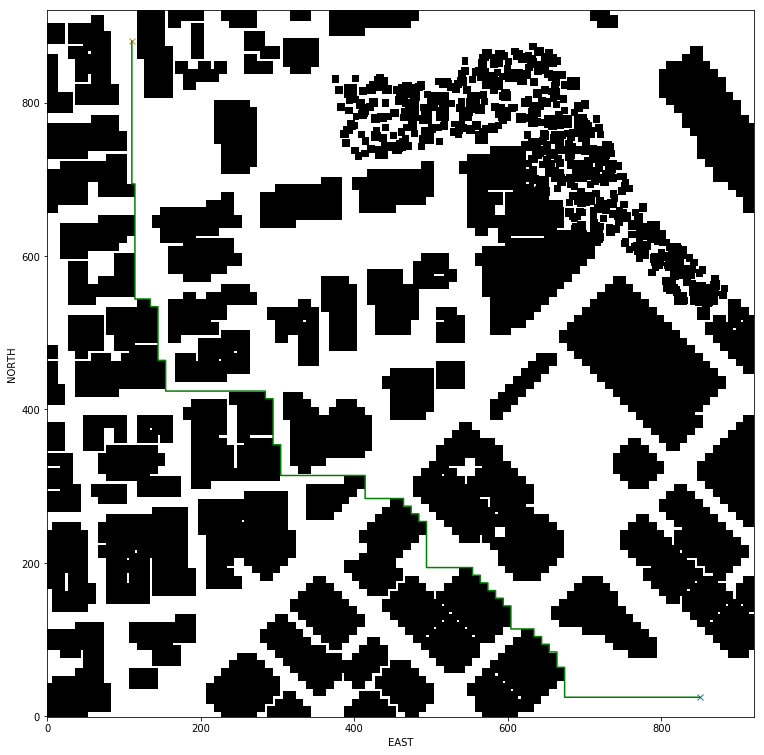

In [14]:
# Definition of start and goal positions
start_ne = (25,  850)
goal_ne = (880, 110)

# Compute the lowest cost path with use `a_star` to c
path, path_cost = a_star(grid, Manhattan_d, start_ne, goal_ne)  # heuristic = Manhattan dist.
#path, path_cost = a_star(grid, Euclidean_d, start_ne, goal_ne)   # heuristic = Euclidean dist.

print('Path cost: ', path_cost)


# Plotting
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()


Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [15]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

The `prune_path` function below returns a new path much shorter than the original. Collinearity method is employed. Bresenham is another option.

In [16]:
# Collinearity method
def prune_path(path):
    '''Prune the path using collinearity method
       If the 3 points are in a line, remove the 2nd point.
       The 3rd point now becomes and 2nd point and the check
       is redone with a new third point on the next iteration.'''
    
    pruned_path = [p for p in path]   # Path to a list
        
    i = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        
        
        if collinearity_check(p1, p2, p3):
            pruned_path.remove(pruned_path[i+1])
        else:
            i += 1
    return pruned_path

Prune the path. Now the path is the same as before but the drone flight will be much smoother, since the waypoints symbolize a change in direction much better.

Lenght of the pruned path vs. original path: 49 vs. 1596 waypoints


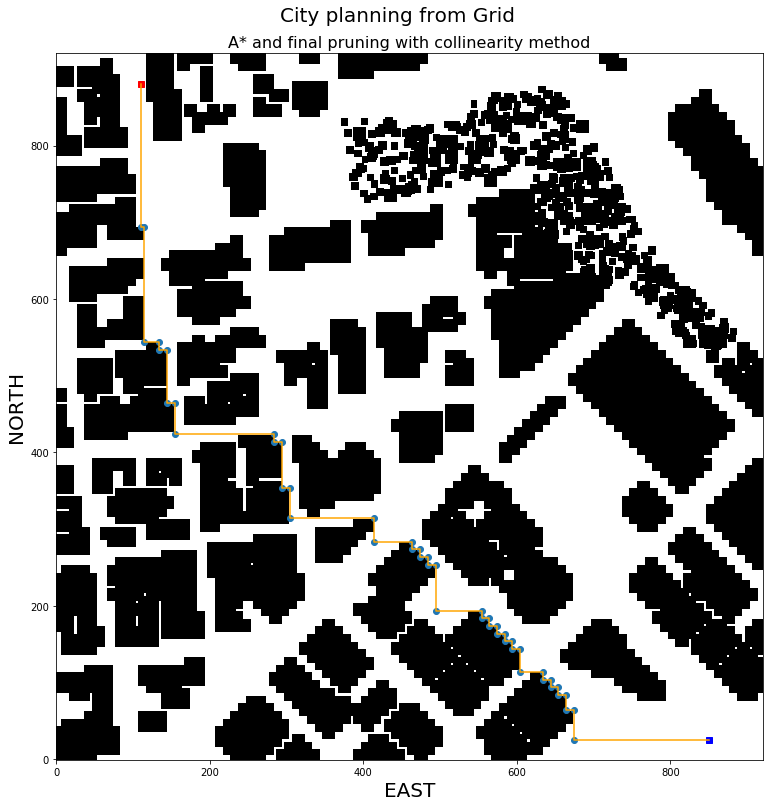

In [20]:
# Prune the path
pruned_path = prune_path(path)

print('Lenght of the pruned path vs. original path: {} vs. {} waypoints'.format(len(pruned_path), len(path)))


# Plotting
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 's', color='blue')
plt.plot(goal_ne[1], goal_ne[0], 's', color='red')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'orange')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.suptitle('City planning from Grid', fontsize=20, x=0.5, y=0.93)
plt.title('A* and final pruning with collinearity method', fontsize=16, x=0.5, y=1.0)

#plt.legend(loc='upper right', fontsize=20)
plt.show()